In [1]:
%load_ext autoreload
%autoreload
ply_path="/data/pkurei/mpeg/dataset/longdress/Ply/longdress_vox10_1051.ply"
import sys, os, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)
from mpeg_process import read_mesh
from visualize import get_subplot_proj, visualize
from utils import load_model, get_model, process_whole
from bf import BilateralFilterv2
from dataloader import normal_noise
import torch
import torch_geometric as tgnn
import pretty_errors
from icecream import ic
# import importlib
# importlib.reload('utils')

In [2]:
parallel=True
model = get_model(
    dataset_type='MPEG',
    bfilter=BilateralFilterv2,
    batch_size=24,
    device=torch.device('cuda:2'),
    gpu_ids=(2, 3),
    gpu_id=2,
    parallel=parallel,
    reg=0.0,
    loss_type='mse',
    collate='gaussian'
)
load_model(
    model=model.module if parallel and False else model,
    optimizer=None,
    f='../model/mpeg-bf-5.0v3sgd+act/178/model-latest.save',
    optim=None,
    e=0,
    evaluate=None,
)

Msg from bf.Embedding.__init__:Created layer (64, 128)
Msg from bf.Embedding.__init__:Created layer (128, 64)


ic| self.collate: 'gaussian'


Msg from bf.BilateralFilterv2.__init__:Created BilateralFilterv2 6 => 64, hidden: [128]
Msg from bf.Embedding.__init__:Created layer (128, 128)
Msg from bf.Embedding.__init__:Created layer (128, 128)


ic| self.collate: 'gaussian'


Msg from bf.BilateralFilterv2.__init__:Created BilateralFilterv2 70 => 128, hidden: [128]
Msg from bf.Embedding.__init__:Created layer (6, 128)
Msg from bf.Embedding.__init__:Created layer (128, 6)


ic| self.collate: 'gaussian'


Msg from bf.BilateralFilterv2.__init__:Created BilateralFilterv2 198 => 6, hidden: [128]
Using filter type BilateralFilterv2
Parallelized model


ic| utils.py:93 in load_model() at 12:29:02.972


Loaded milestone with epoch 0 at ../model/mpeg-bf-5.0v3sgd+act/178/model-latest.save


In [3]:
%%time
reconstructed, noisy, mesh, mse_error = process_whole(
    model,
    ply_path,
    noise_generator=normal_noise,
    sigma=5.0,
    batch_size=4 * 2,
    parallel=True,
    n_patch=200,
    patch_size=10240
)

Using 16/16 cores/threads of CPU
Loading PLY file /data/pkurei/mpeg/dataset/longdress/Ply/longdress_vox10_1051.ply
Containing 765821 points


ic| orig_mesh.color.shape: torch.Size([765821, 3])


Total points: 765821 @ /data/pkurei/mpeg/dataset/longdress/Ply/longdress_vox10_1051.ply


ic| 'Taking patches of ', n_patch: 200


Loading PLY file /data/pkurei/mpeg/dataset/longdress/Ply/longdress_vox10_1051.ply
Containing 765821 points
Loaded PLY file /data/pkurei/mpeg/dataset/longdress/Ply/longdress_vox10_1051.ply


ic| cmean.shape: torch.Size([200, 1, 3])
    cstd.shape: torch.Size([200, 1, 3])
ic| pmean.shape: torch.Size([200, 1, 3])
    pstd.shape: torch.Size([200, 1, 3])
ic| len(loader): 25
  0%|          | 0/25 [00:00<?, ?it/s]/home/pkurei/.conda/envs/rei/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
ic| loss: [tensor([0.4878, 0.4978], device='cuda:2'),
           tensor([0.4878, 0.4978], device='cuda:2')]
  4%|▍         | 1/25 [00:21<08:43, 21.83s/it]ic| loss: [tensor([0.5274, 0.4624], device='cuda:2'),
           tensor([0.5274, 0.4624], device='cuda:2')]
  8%|▊         | 2/25 [00:40<08:01, 20.93s/it]ic| loss: [tensor([0.5074, 0.5260], device='cuda:2'),
           tensor([0.5074, 0.5260], device='cuda:2')]
 12%|█▏        | 3/25 [00:59<07:27, 20.33s/it]ic| loss: [tensor([0.4561, 

CPU times: user 20min 15s, sys: 4min 11s, total: 24min 27s
Wall time: 8min 58s


In [4]:
from utils import mse
noisy=noisy.clamp(0., 255.)
reconstructed = reconstructed.clamp(0, 255.)
ic(mse(noisy,mesh.color))
ic(mse(reconstructed,mesh.color))

ic| mse(noisy,mesh.color): tensor(6044.7954)
ic| mse(reconstructed,mesh.color): tensor(748.7606)


tensor(748.7606)

In [5]:
from mpl_toolkits.mplot3d import proj3d, Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
pos = mesh.pos
color = mesh.color
#Make sure these are floating point values:                                                                                                                                                                                              
x_scale = pos[:, 0].max()
y_scale = pos[:, 1].max()
z_scale = pos[:, 2].max()

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0
print(scale)

mpl.rcParams['legend.fontsize'] = 10

def get_subplot_proj(ax):
    def short_proj():
        return np.dot(Axes3D.get_proj(ax), scale)

    return short_proj

[[0.45355731 0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.31422925 0.        ]
 [0.         0.         0.         1.        ]]


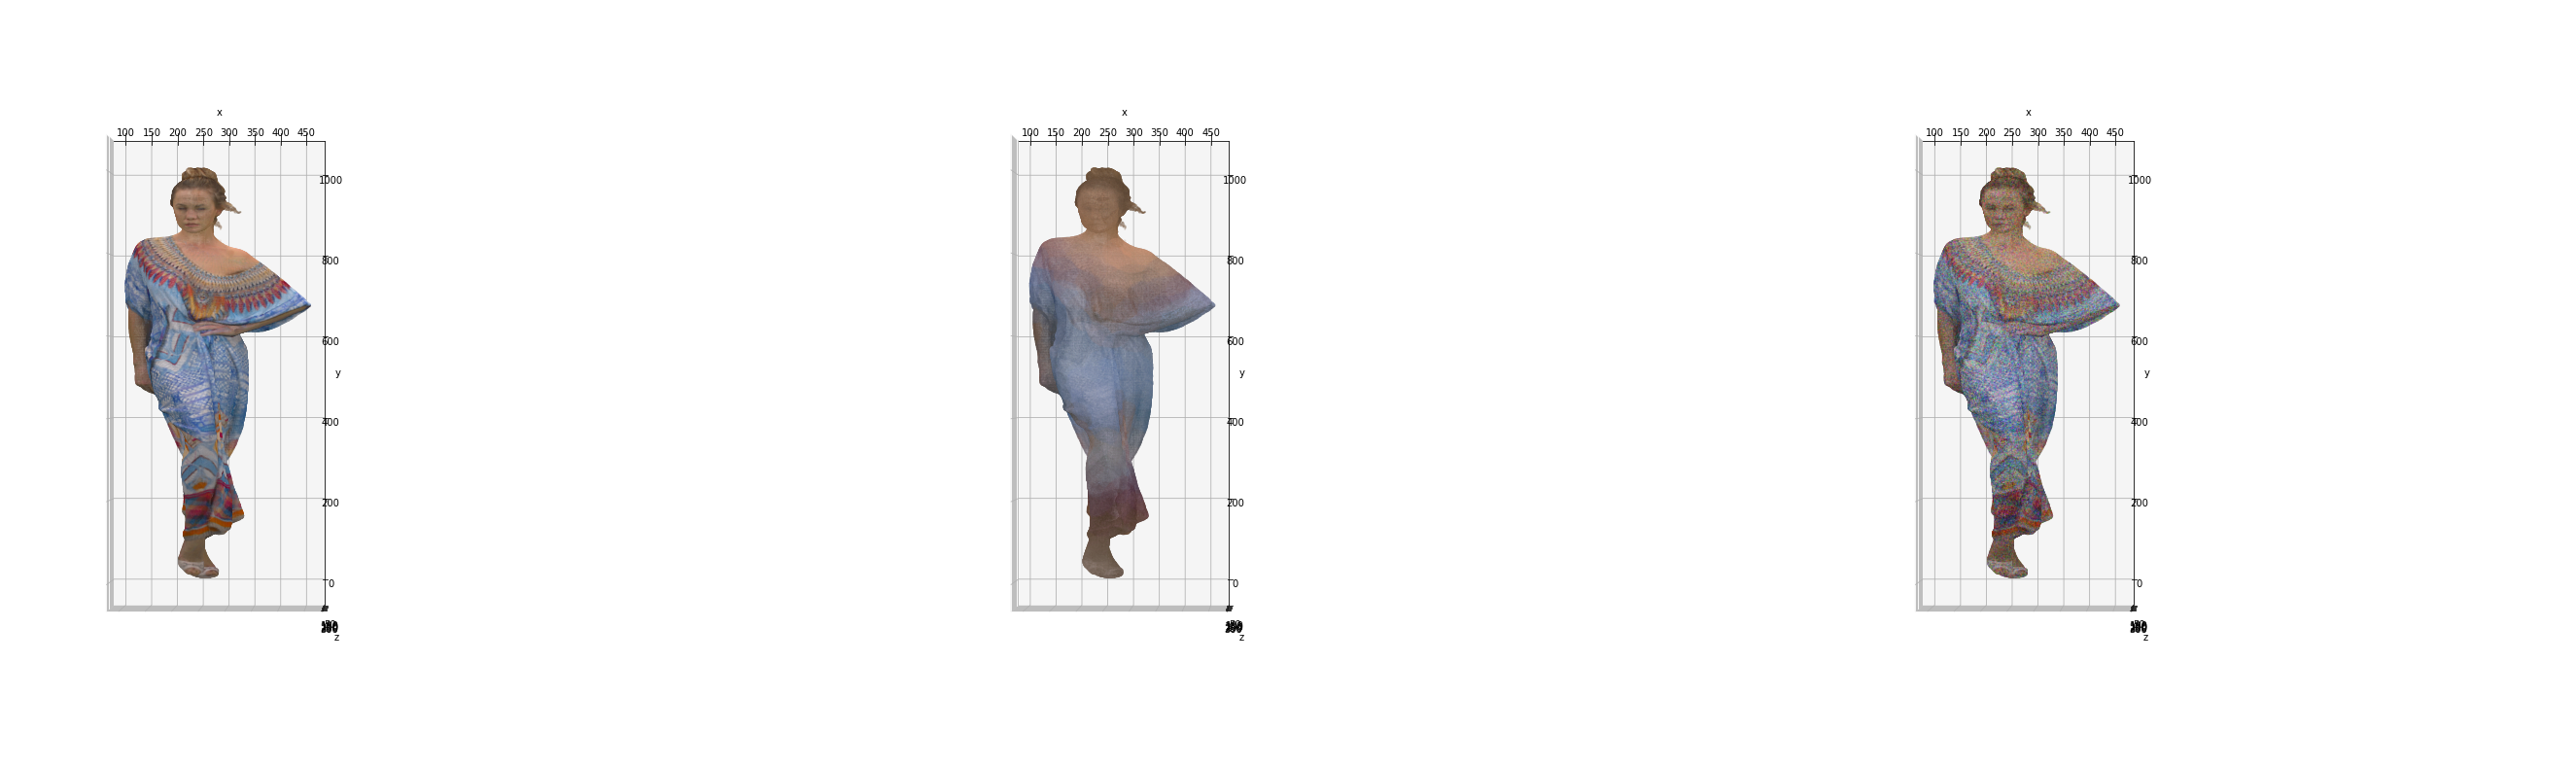

CPU times: user 52.3 s, sys: 1.37 s, total: 53.7 s
Wall time: 52 s


In [6]:
%%time
cm = 1/2.54
sz=0.01
fig = plt.figure(figsize=(120 * cm, 40 * cm))
# fig.subplots_adjust(bottom=-0.15,top=1.2, left=0.1, right=0.1)
# fig.subplots_adjust(bottom=-0.2,top=1.2, left=-0.2, right=1.2)
ax = fig.add_subplot(131, projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.set_title('Sample Point Cloud')



ax.get_proj=get_subplot_proj(ax)
ax.scatter(pos[:,0],   # x
           pos[:,1],   # y
           pos[:,2],   # z
           facecolors=color.numpy()/255., s=sz# height data for color
          )
ax.view_init(90, -90)
ax = fig.add_subplot(132, projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


ax.get_proj=get_subplot_proj(ax)
ax.scatter(pos[:,0],   # x
           pos[:,1],   # y
           pos[:,2],   # z
           facecolors=reconstructed.numpy()/255., s=sz# height data for color
          )
ax.view_init(90, -90)

ax = fig.add_subplot(133, projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


ax.get_proj=get_subplot_proj(ax)
ax.scatter(pos[:,0],   # x
           pos[:,1],   # y
           pos[:,2],   # z
           facecolors=noisy.numpy()/255., s=sz# height data for color
          )
ax.view_init(90, -90)
plt.show()
fig.savefig('test-bf5RA.png', dpi=300)